Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters found by GridSearchCV:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9997

Classification Report:
                  precision    recall  f1-score   support

   Bearing_fault       1.00      1.00      1.00      1080
    Normal_state       1.00      1.00      1.00      1080
Unbalance_weight       1.00      1.00      1.00      1080

        accuracy                           1.00      3240
       macro avg       1.00      1.00      1.00      3240
    weighted avg       1.00      1.00      1.00      3240



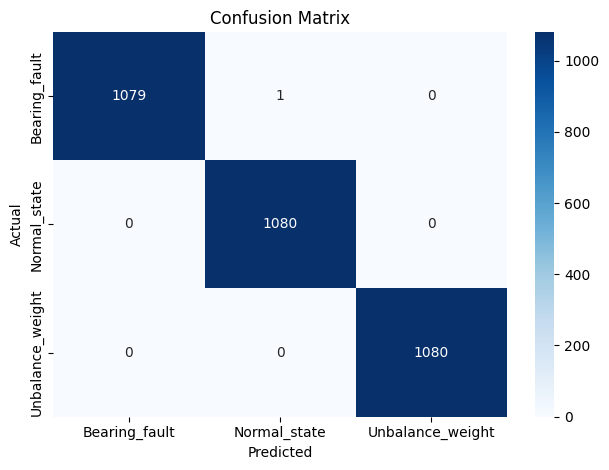


Cross-validated accuracy scores: [1.         0.96265432 1.         0.98240741 1.        ]
Mean cross-validated accuracy: 0.9890


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
csv_path = 'final_dataset/CSVs/5s.csv'  # Replace with other CSVs in a loop if needed
numerical_cols = ['mean_flow', 'std_flow', 'edge_ratio', 'keypoint_count', 'fft_peak']
categorical_col = 'view'

# Load dataset
df = pd.read_csv(csv_path)

# Encode target labels
labels = df['class'].astype(str).values
label_names = sorted(set(labels))
label_to_index = {name: i for i, name in enumerate(label_names)}
y = np.array([label_to_index[label] for label in labels])

# Encode categorical 'view' column (0 for 'front', 1 for 'angle')
view_mapping = {'front': 0, 'angle': 1}
df['view_encoded'] = df[categorical_col].map(view_mapping)

# Combine features
X = df[numerical_cols + ['view_encoded']].values.astype(np.float32)

# Normalize numerical features
scaler = StandardScaler()
X[:, :-1] = scaler.fit_transform(X[:, :-1])  # Only normalize numerical part

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train Random Forest with modifications
clf = RandomForestClassifier(
    n_estimators=50,  # Reduced number of estimators
    max_depth=10,  # Limit the depth of the trees
    min_samples_split=5,  # Increase min samples for splitting a node
    min_samples_leaf=3,  # Increase min samples for a leaf
    random_state=42,
    class_weight='balanced',  # Add class weight for handling imbalance
    max_features='sqrt'  # Use square root of features for splitting
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters from grid search
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the best model from grid search
best_clf = grid_search.best_estimator_

# Test the model
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

# Detailed report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Cross-validation for better evaluation
cv_scores = cross_val_score(best_clf, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validated accuracy scores: {cv_scores}")
print(f"Mean cross-validated accuracy: {cv_scores.mean():.4f}")
